In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

import tensorflow as tf

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

#from jax.experimental import stax
from jax.example_libraries import stax
from jax.example_libraries import optimizers
#from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

def lagrangian(q, q_dot, m1, m2, l1, l2, g):
    t1, t2 = q     # theta 1 and theta 2
    w1, w2 = q_dot # omega 1 and omega 2

      # kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                        2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
    T = T1 + T2

      # potential energy (V)
    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2

    return T - V

def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    t1, t2, w1, w2 = state
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
    a2 = (l1 / l2) * jnp.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
    (g / l1) * jnp.sin(t1)
    f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    return jnp.stack([w1, w2, g1, g2])

def equation_of_motion(lagrangian, state, t=None):
    q, q_t = jnp.split(state, 2)
    q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
    return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
    @partial(jax.jit, backend='cpu')
    def f(initial_state):
        return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
    return f(initial_state)

# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
    L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
    return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
    k1 = h * f(x, t)
    k2 = h * f(x + k1/2, t + h/2)
    k3 = h * f(x + k2/2, t + h/2)
    k4 = h * f(x + k3, t + h)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

In [3]:
time_step = 0.01
N = 1500
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
#t = np.arange(N, dtype=np.float32) # time steps 0 to N
t = np.linspace(0, 100, num=1501)
%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step

Wall time: 4.49 s
Wall time: 2.74 s
Wall time: 788 ms


In [4]:
def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2

In [5]:
L1, L2 = 1., 1.
m1, m2 = 1., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#z0=[np.pi/2,0,np.pi/2,0]
#z0=[0.1,0,0.1,0]
z0=[3*np.pi/7, 3*np.pi/4, 0, 0]
tmax, dt = 50, 0.1
#t = np.arange(0, tmax+dt, dt)

In [6]:
theta1, theta2, w1, w2 = x_train[:, 0], x_train[:, 1], x_train[:, 2], x_train[:, 3]

In [7]:
#x1, y1, x2, y2 =radial2cartesian(theta1, theta2, L1, L2)

In [8]:
x1_new, y1_new, x2_new, y2_new, vx1_new, vy1_new, vx2_new, vy2_new=to_cartesian(theta1, w1, theta2, w2, L1, L2)

In [9]:
x1_new[180:190]

array([-0.1906413 ,  0.28824767,  0.6484238 ,  0.8604606 ,  0.96550894,
        0.9986011 ,  0.99598783,  0.9871711 ,  0.9873482 ,  0.99639237],
      dtype=float32)

In [10]:
# Setting up data to forecast the position of the pendulum after 20 steps
# We'll base our prediction on the following 20 swings of the pendulum


# Timesteps ahead for our prediction
timeframe = 20 


# Initialising two lists (X and Y) to store target positions (Y) and input sequences (X)
X, Y = [], []


# Looping through positions
# We will stop 'timeframe' steps before the end to avoid going out of bounds

for i in range(len(x1_new) - timeframe):
    
    # Stack the next 'timeframe' positions of both masses to serve as the input sequence
    X.append(np.vstack((x1_new[i:i+timeframe], y1_new[i:i+timeframe], x2_new[i:i+timeframe], y2_new[i:i+timeframe],vx1_new[i:i+timeframe], vy1_new[i:i+timeframe], vx2_new[i:i+timeframe], vy2_new[i:i+timeframe])).T)
    
    # Record the positions of both masses 20 steps ahead from the current timestep to set as the prediction target
    Y.append([x1_new[i+timeframe], y1_new[i+timeframe], x2_new[i+timeframe], y2_new[i+timeframe], vx1_new[i+timeframe], vy1_new[i+timeframe], vx2_new[i+timeframe], vy2_new[i+timeframe]])


# Converting position sequences to numpy array
X = np.array(X)

# Converting targets (positions 20 steps ahead) to numpy array
Y = np.array(Y)

In [ ]:
#Dodać wage do długości wahadła

In [11]:


from tensorflow.keras.models import Sequential # Importing the sequential model class
from tensorflow.keras.layers import LSTM, Dense # Importing LSTM and Dense layer classes


# ------ Defining an RNN (Recurrent Neural Network) model with LSTM (Long Short-Term Memory) layers --------

model = Sequential([
    
    LSTM(64, input_shape=(timeframe, 8), return_sequences=True),  # First LSTM layer with 64 units, returning sequences
    LSTM(32),  # Second LSTM layer with 32 units
    Dense(8)   # Output layer for future x1, y1, x2, y2 positions

])

# Compiling model with MSE loss function and Adam optimizer
model.compile(optimizer='adam', loss='mse')

In [12]:
# Training the model using input sequences to predict future positions, validating on 20% of the data
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
37/37 [==============================] - 16s 151ms/step - loss: 3.2720 - val_loss: 2.5847
Epoch 2/50
37/37 [==============================] - 2s 66ms/step - loss: 2.0836 - val_loss: 1.6952
Epoch 3/50
37/37 [==============================] - 2s 61ms/step - loss: 1.3490 - val_loss: 1.2615
Epoch 4/50
37/37 [==============================] - 2s 63ms/step - loss: 0.9445 - val_loss: 1.0459
Epoch 5/50
37/37 [==============================] - 2s 65ms/step - loss: 0.6951 - val_loss: 0.8431
Epoch 6/50
37/37 [==============================] - 3s 68ms/step - loss: 0.5230 - val_loss: 0.7866
Epoch 7/50
37/37 [==============================] - 2s 64ms/step - loss: 0.4234 - val_loss: 0.6038
Epoch 8/50
37/37 [==============================] - 2s 60ms/step - loss: 0.3469 - val_loss: 0.6245
Epoch 9/50
37/37 [==============================] - 2s 65ms/step - loss: 0.2953 - val_loss: 0.4881
Epoch 10/50
37/37 [==============================] - 2s 66ms/step - loss: 0.2458 - val_loss: 0.4536
Epoch 1

In [13]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1= cart_coords[:,0]
    y1= cart_coords[:,1]
    x2= cart_coords[:,2]
    y2 = cart_coords[:,3]
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

In [59]:
def make_plot1(i, x1, y1, x2, y2, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    #x1, y1, x2, y2 = cart_coords
    
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

In [14]:
# Choosing a set of different initial conditions

#initial_conditions = [np.pi/4, 0, np.pi/4, 0]
#initial_conditions = [3*np.pi/7, 0, 3*np.pi/4, 0]
initial_conditions = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

# Defining a figure and its subplots
#fig, axes = plt.subplots(len(initial_conditions), 2, figsize=(12, 6*len(initial_conditions))) 

# Setting the main title for the figure
#fig.suptitle('Comparing Network Prediction and solve_ivp Solution', y=1.02, fontsize=15)  

# Looping through each set of initial conditions
# Computing the trajectory / motion of the double pendulum for the specified initial conditions
#ret_var = solve_ivp(rhs, (0, tmax), z0_var, t_eval=t, args=(L1, L2, m1, m2, g))
ret_var = jax.device_get(solve_analytical(initial_conditions, t))
theta1, theta2, w1, w2 = ret_var[:, 0], ret_var[:, 1], ret_var[:, 2], ret_var[:, 3]

# Converting angular motion data to Cartesian coordinates
positions_var = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# Extracting the cartesian coordinates of both pendulum masses for the simulated trajectory / motion
x1_var, y1_var, x2_var, y2_var, vx1_var, vy1_var, vx2_var, vy2_var = positions_var

# Preparing the data sequence for the network's prediction
X_var = [np.vstack((x1_var[j:j+timeframe], y1_var[j:j+timeframe], x2_var[j:j+timeframe], y2_var[j:j+timeframe], vx1_var[j:j+timeframe], vy1_var[j:j+timeframe], vx2_var[j:j+timeframe], vy2_var[j:j+timeframe])).T for j in range(len(x1_var) - timeframe)]

X_var = np.array(X_var)

# Using the trained RNN model to predict the future positions 
# (More simply we are generating predictions using the trained model)

predictions = model.predict(X_var)

47/47 [==============================] - 4s 24ms/step


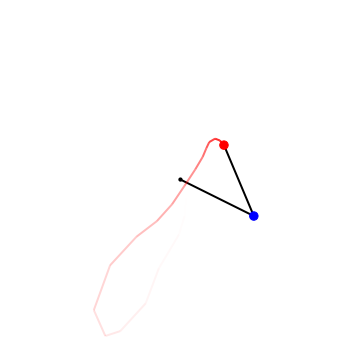

In [15]:
L1, L2 = 1, 1
#theta1, theta2 = predictions[:, 0], predictions[:, 1]
#cart_coords = radial2cartesian(theta1, theta2, L1, L2)
cart_coords = predictions

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 400
for i in range(0, N, di):
  #print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append( fig2image(fig) )

In [16]:
import importlib
importlib.reload(proglog)
print("Base-predicted dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

Base-predicted dynamics of the double pendulum:


In [17]:
predictions[:,0]

array([-0.89567035, -0.84931475, -0.8305058 , ...,  0.8815081 ,
        0.8682836 ,  0.77730906], dtype=float32)

In [18]:
x1_new

array([0.9749279 , 0.970309  , 0.95439947, ..., 0.781818  , 0.7643258 ,
       0.7231324 ], dtype=float32)

In [19]:
predictions[0]

array([-0.89567035,  0.19366328, -1.5576333 , -0.43037733,  0.46207812,
        1.9844847 ,  0.6145098 ,  1.7047552 ], dtype=float32)

In [21]:
predictions[0][0]

-0.89567035

In [20]:
import math

def kartezjanskie_na_radialne_z_predkosciami(x1, y1, x2, y2, vx1, vy1, vx2, vy2, L1, L2):
    # Obliczenie kąta theta1
    theta1 = math.atan2(x1, -y1)
    
    # Obliczenie współrzędnych dla wahadła 2 w układzie współrzędnych kartezjańskich
    x2_prime = x2 - x1
    y2_prime = y2 - y1
    
    # Obliczenie kąta theta2
    theta2 = math.atan2(x2_prime, -y2_prime)
    
    # Obliczenie prędkości kątowych
    theta1_dot = (vx1 * math.cos(theta1) + vy1 * math.sin(theta1)) / L1
    theta2_dot = ((vx2 - vx1) * math.cos(theta2) + (vy2 - vy1) * math.sin(theta2)) / L2
    
    return theta1, theta2, theta1_dot, theta2_dot


In [31]:
in_cond=kartezjanskie_na_radialne_z_predkosciami(predictions[0][0],predictions[0][1],predictions[0][2],predictions[0][3],predictions[0][4],predictions[0][5],predictions[0][6],predictions[0][7],1,1)

In [32]:
in_cond

(-1.783739827265367,
 -0.814878126347223,
 -2.0373158565311678,
 0.3081045247643457)

In [57]:
#initial_conditions = [np.pi/4, np.pi/4, 0, 0]
#ret_var = solve_ivp(rhs, (0, tmax), z0_var, t_eval=t, args=(L1, L2, m1, m2, g))
#in_cond = np.array(in_cond)
in_cond = np.array([-1.783739827265367, -0.814878126347223, -2.0373158565311678, 0.3081045247643457], dtype=np.float32)
ret_var = jax.device_get(solve_analytical(in_cond, t))
#ret_var = np.array(ret_var)
theta1, theta2, w1, w2 = ret_var[:, 0], ret_var[:, 1], ret_var[:, 2], ret_var[:, 3]
positions_var = to_cartesian(theta1, w1, theta2, w2, L1, L2)
x1_var, y1_var, x2_var, y2_var, vx1_var, vy1_var, vx2_var, vy2_var = positions_var
X_var = [np.vstack((x1_var[j:j+timeframe], y1_var[j:j+timeframe], x2_var[j:j+timeframe], y2_var[j:j+timeframe], vx1_var[j:j+timeframe], vy1_var[j:j+timeframe], vx2_var[j:j+timeframe], vy2_var[j:j+timeframe])).T for j in range(len(x1_var) - timeframe)]
X_var = np.array(X_var)
predictions2 = model.predict(X_var)

47/47 [==============================] - 2s 27ms/step


In [34]:
#initial_conditions = [np.pi/4, np.pi/4, 0, 0]
#ret_var = solve_ivp(rhs, (0, tmax), z0_var, t_eval=t, args=(L1, L2, m1, m2, g))
#in_cond = np.array(in_cond)
in_cond = [-1.783739827265367, -0.814878126347223, -2.0373158565311678, 0.3081045247643457]
ret_var = jax.device_get(solve_analytical(in_cond, t))

In [39]:
ret_var = np.array(ret_var)
ret_var[:,0]

array([-1.7837398 , -0.8148781 , -2.0373158 ,  0.30810452], dtype=float32)

In [45]:
ret_var.shape

(4, 1501)

In [48]:
X_var

array([], dtype=float64)

In [49]:
timeframe

20

In [56]:
len(x1_var)

1501

In [51]:
positions_var

(array([-0.97741306, -0.727642  , -0.8931391 ,  0.30325297], dtype=float32),
 array([ 0.2113378 , -0.6859571 ,  0.44978046, -0.95291007], dtype=float32),
 array([-1.9243948, -1.4423943, -1.8785459,  0.5853381], dtype=float32),
 array([ 0.5326252 , -1.3853347 ,  0.27956426, -1.9122994 ], dtype=float32),
 array([ 0.41666487, -0.53021896,  0.36704978,  0.41442266], dtype=float32),
 array([1.9270271 , 0.5624398 , 0.72885895, 0.13188538], dtype=float32),
 array([ 1.0615138, -1.045101 ,  0.3245096,  1.0647514], dtype=float32),
 array([3.8276935 , 1.0886407 , 0.97513044, 0.32309875], dtype=float32))

In [52]:
x1_var

array([-0.97741306, -0.727642  , -0.8931391 ,  0.30325297], dtype=float32)

In [54]:
t.shape

(1501,)

In [58]:
in_cond

array([-1.7837398 , -0.8148781 , -2.0373158 ,  0.30810452], dtype=float32)

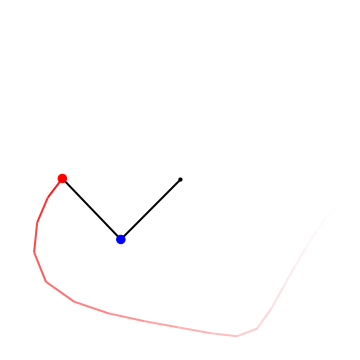

In [60]:
L1, L2 = 1, 1
#theta1, theta2 = predictions[:, 0], predictions[:, 1]
#cart_coords = radial2cartesian(theta1, theta2, L1, L2)
#cart_coords2 = predictions2

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 400
for i in range(0, N, di):
  #print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot1(i, x1_var, y1_var, x2_var, y2_var, L1, L2)
  images.append( fig2image(fig) )

In [61]:
import importlib
importlib.reload(proglog)
print("Base-predicted dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

Base-predicted dynamics of the double pendulum:
